In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection-dataset/submission.csv
/kaggle/input/face-mask-detection-dataset/train.csv
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/meta.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3758.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3335.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4660.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4543.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/5313.jpeg.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3553.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4360.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical 

# During pandemic COVID-19, WHO has made wearing masks compulsory to protect against this deadly virus. In this tutorial we will develop a machine learning project , Given an input image, our face mask detection model should be able to detect if a person is wearing a face mask or not with a good amount of accuracy

**To successfully complete this project, there are three major parts we need to think about:**

**Part 1: Create a training dataset – We should be able to create a training dataset of face images with proper bounding boxes of human faces and annotations indicating whether the person is wearing a face mask or not.**

**Part 2: Train an image classification model – We should be able to create an image classification model like a Convolutional Neural Network for face mask detection. The accuracy of detection heavily relies on the type and quality of the model we will be building.**

**Part 3: Make predictions – We should be able to detect faces on images and make predictions on whether or not the person is wearing a face mask using our trained image classification model.**

# Importing Dataset and important libraries

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches


**For Reading images and images manipulation**

In [4]:
import cv2

**For label encoding the target variable**

In [5]:
from sklearn.preprocessing import LabelEncoder

**For tensor based operations**

In [6]:
from tensorflow.keras.utils import to_categorical, normalize

**For Machine Learning**

In [9]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

**For Face detection**

In [13]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.4 MB/s eta 0:00:00a 0:00:01


In [14]:
from mtcnn.mtcnn import MTCNN

# Part 1 : Creating a dataset

In [15]:
train_data=pd.read_csv('/kaggle/input/face-mask-detection-dataset/train.csv')
train_data.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


**The dataframe shows that it contains:** 

**- Name: Image Filename**

**- x1,x2,y1,y2: Bounding Box coordinates**

**- classname: Bounding Box Label**

![](http://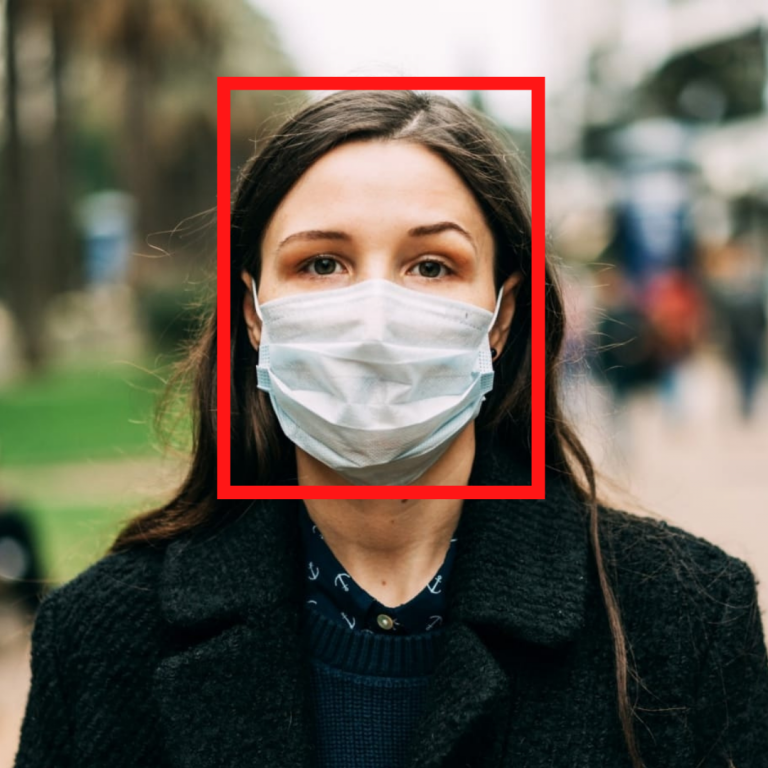)

In [16]:
print(f"Total number of rows:{len(train_data)}")

Total number of rows:15412


In [17]:
print(f"Total number of Unique Images:{len(train_data['name'].unique())}")

Total number of Unique Images:4326


In [18]:
train_data['classname'].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [19]:
# we only need face_with_mask and face_no_mask
choice=['face_with_mask','face_no_mask']
train_data=train_data[train_data['classname'].isin(choice)].reset_index(drop=True)
train_data.sort_values('name',axis=0,inplace=True)


In [20]:
train_data['classname'].unique()

array(['face_no_mask', 'face_with_mask'], dtype=object)

In [21]:
train_data.head()

,name,x1,x2,y1,y2,classname
4974,1801.jpg,451,186,895,697,face_no_mask
1327,1802.jpg,110,71,273,272,face_with_mask
5524,1803.jpg,126,75,303,333,face_with_mask
2214,1804.jpg,112,113,262,307,face_with_mask
2330,1805.jpg,728,180,853,336,face_with_mask


<BarContainer object of 2 artists>

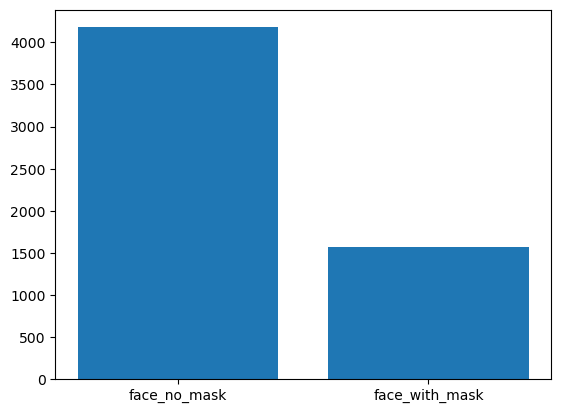

In [22]:
x_axis=['face_no_mask','face_with_mask']
y_axis=train_data.classname.value_counts()
plt.bar(x_axis,y_axis)

**There's inbalance in our dataset but its okay now for our project**

In [41]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

In [42]:
images_filenames=os.listdir(images)
print(f"Number of Images:{len(images_filenames)}")

Number of Images:6024


In [43]:
print(images_filenames[:5])

['0664.jpg', '4353.png', '6234.jpg', '1269.jpg', '6241.jpg']


**We will not be using the 6024 images since we need to filter it to be suited for our dataframe**

In [48]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()


In [49]:
train_images=a[1698:]
test_images=a[:1698]

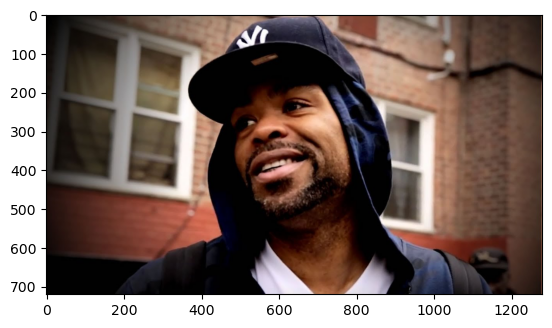

In [50]:
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

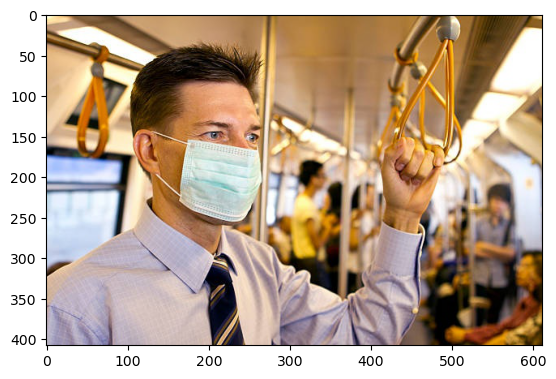

In [51]:
img=plt.imread(os.path.join(images,train_images[1]))
plt.imshow(img)
plt.show()


[[112, 113, 262, 307]]


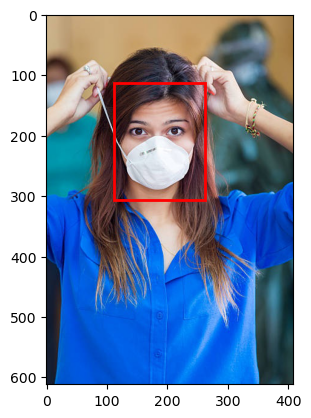

In [54]:
bbox=[]
for i in range(len(train_data)):
    arr=[]
    for j in train_data.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train_data["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train_data[train_data["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


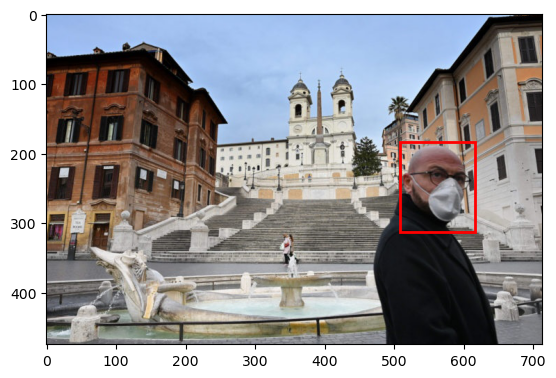

In [55]:
image=train_images[5]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [58]:
img_size=50
data=[]
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/'
def create_data():
       for i in range(len(train_data)):
            arr=[]
            for j in train_data.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()   

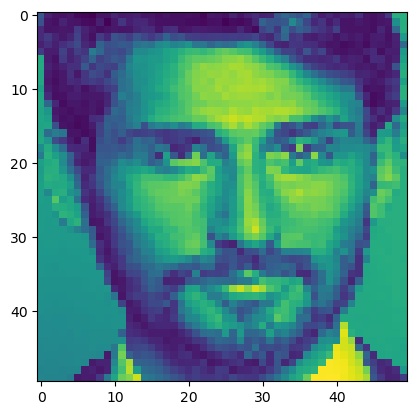

In [59]:
data[0][0]
plt.imshow(data[0][0])

In [60]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)

In [62]:
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [64]:
import tensorflow as tf
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

In [65]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [70]:
opt = tf.keras.optimizers.legacy.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x,y,epochs=30,batch_size=5)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
1150/1150 [==============================] - 13s 10ms/step - loss: 0.5561 - accuracy: 0.7276
Epoch 2/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.4817 - accuracy: 0.7681
Epoch 3/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.4374 - accuracy: 0.8003
Epoch 4/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.4020 - accuracy: 0.8189
Epoch 5/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3660 - accuracy: 0.8381
Epoch 6/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3334 - accuracy: 0.8541
Epoch 7/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3018 - accuracy: 0.8647
Epoch 8/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.2839 - accuracy: 0.8767
Epoch 9/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.2575 - accuracy: 0.8949
Epoch 10/30
1150/1150 [==============================] - 12s 10m

1/1 [==============================] - 0s 172ms/step


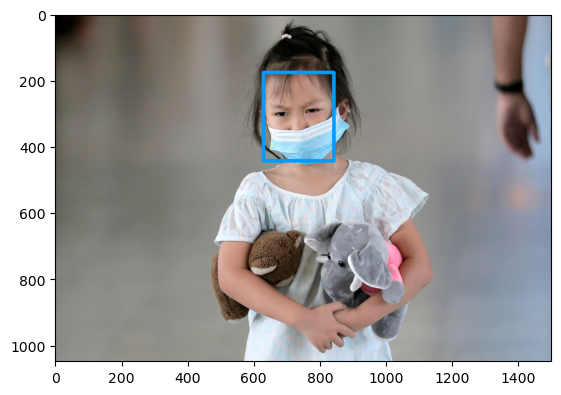

In [74]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[3]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)